# Data Exploration

This notebook will walk you through different ways we can look at data to gain a better understanding of our data, build intuition, and start hypothesis testing. By the end of this workshop, participants will have some data exploration skills in their toolbox to conduct which lays a solid foundation for any subsequent machine learning or data analysis projects.

It is assumed that you have two datafiles required stored in 'OUTPUT/' folder:
1. CQ_Data_20240602.txt
2. WtshdAttributeTable_20240602.txt

In [30]:
# Import all libraries at the top of your code so you can easily see and organize all the packges you are using. 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [117]:
# Set up the filepaths
outputDataFilepath ='C:/Users/danyk/Work/4_Data_Science/DataExplorationWorkshop/INPUTS/'

In [118]:
CQ = pd.read_csv(outputDataFilepath+'CQ_Data_20240602.txt', sep=",", dtype={'SITE': str, 'HUC02': str})
WtshdAtt = pd.read_csv(outputDataFilepath+'WtshdAttributeTable_20240602.txt', sep=",", dtype={'SITE': str, 'HUC02': str})

In [114]:
cols_to_use = WtshdAtt.columns.difference(CQ.columns)
WtshdAtt= WtshdAtt.filter(cols_to_use)
CQ.head()

,Site,Name,Area_SQKM,HUC02,Lat,Long,STATE,HCDN-2009,CLASS,AGGECOREGION,Date,Q_m3s,Conc
0,1022260,"Pleasant River near Epping, Maine",162.0,01,44.697778,-67.787222,ME,NaN,Ref,NorthEast,1980-10-24,3.228121,0.01
1,1022260,"Pleasant River near Epping, Maine",162.0,01,44.697778,-67.787222,ME,NaN,Ref,NorthEast,1981-05-13,13.818621,0.01
2,1022500,"Narraguagus River at Cherryfield, Maine",573.6,01,44.607972,-67.935242,ME,yes,Ref,NorthEast,1980-01-22,6.229706,0.06
3,1022500,"Narraguagus River at Cherryfield, Maine",573.6,01,44.607972,-67.935242,ME,yes,Ref,NorthEast,1980-02-20,3.398022,0.06
4,1022500,"Narraguagus River at Cherryfield, Maine",573.6,01,44.607972,-67.935242,ME,yes,Ref,NorthEast,1980-03-24,40.776259,0.08


I like to start by understanding the distribution of our data. There are a few ways to go about it. 

- '.describe()' will print out the summary statistics of your variable.
- 'boxplots' can be used to visualize the summary statistics but not the most intuitive to understand the distribution. 
- 'histogram' are great to see the distribution, but understanding the summary statistics can be a challenge.

Using multiple approaches can help get a better understanding of the data. 

In [27]:
WtshdAtt['AREA_SQKM'].describe()

count    362680.000000
mean       2548.044987
std        6133.854176
min           0.200000
25%         122.000000
50%         459.800000
75%        1774.200000
max       49802.300000
Name: AREA_SQKM, dtype: float64

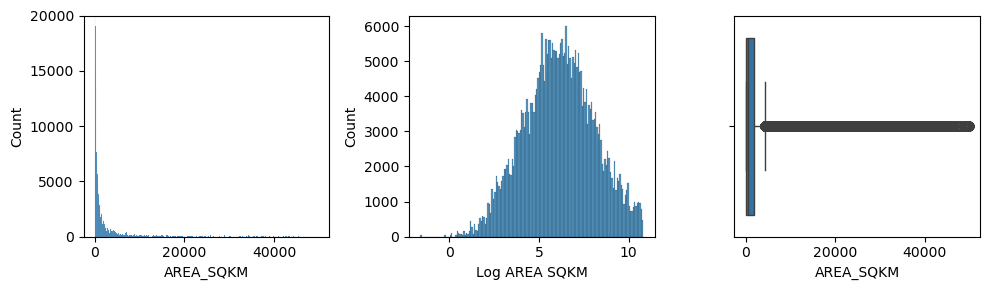

In [100]:
fig, axs = plt.subplots(1,3, figsize=(10, 3))

ax1 = plt.subplot(1,3,1)
sns.histplot(data=WtshdAtt, x="AREA_SQKM", ax=ax1)
ax1.set_ylim(0,20000)

ax2 = plt.subplot(1,3,2)
sns.histplot(x=np.log(WtshdAtt['AREA_SQKM']), ax=ax2)
plt.tight_layout()
plt.xlabel('Log AREA SQKM')

ax3 = plt.subplot(1,3,3)
sns.boxplot(x=WtshdAtt['AREA_SQKM'], ax=ax3)
plt.tight_layout()

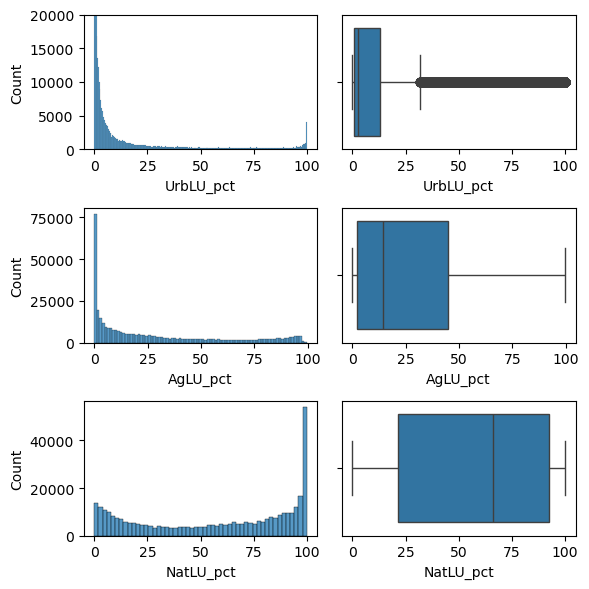

In [101]:
fig, axs = plt.subplots(3,2, figsize=(6, 6))

ax1 = plt.subplot(3,2,1)
sns.histplot(data=WtshdAtt, x="UrbLU_pct", ax=ax1)
ax1.set_ylim(0,20000)


ax2 = plt.subplot(3,2,2)
sns.boxplot(x=WtshdAtt['UrbLU_pct'], ax=ax2)

ax3 = plt.subplot(3,2,3)
sns.histplot(data=WtshdAtt, x="AgLU_pct", ax=ax3)
#ax1.set_ylim(0,40000)

ax4 = plt.subplot(3,2,4)
sns.boxplot(x=WtshdAtt['AgLU_pct'], ax=ax4)

ax5 = plt.subplot(3,2,5)
sns.histplot(data=WtshdAtt, x="NatLU_pct", ax=ax5)
#ax1.set_ylim(0,40000)

ax6 = plt.subplot(3,2,6)
sns.boxplot(x=WtshdAtt['NatLU_pct'], ax=ax6)
plt.tight_layout()

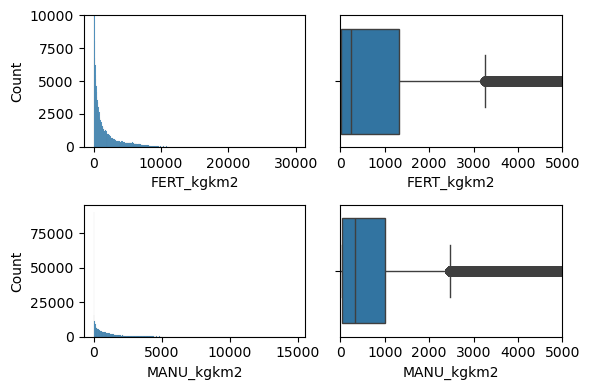

In [102]:
fig, axs = plt.subplots(2,2, figsize=(6, 4))

ax1 = plt.subplot(2,2,1)
sns.histplot(data=WtshdAtt, x="FERT_kgkm2", ax=ax1)
ax1.set_ylim(0,10000)

ax2 = plt.subplot(2,2,2)
sns.boxplot(x=WtshdAtt['FERT_kgkm2'], ax=ax2)
ax2.set_xlim(0,5000)

ax3 = plt.subplot(2,2,3)
sns.histplot(data=WtshdAtt, x="MANU_kgkm2", ax=ax3)
ax4.set_ylim(0,5000)

ax4 = plt.subplot(2,2,4)
sns.boxplot(x=WtshdAtt['MANU_kgkm2'], ax=ax4)
ax4.set_xlim(0,5000)
plt.tight_layout()

In [103]:
WtshdAtt.head()

,SITE,YEAR,NAME,LAT,LONG,STATE,AREA_SQKM,HUC02,HCDN-2009,CLASS,...,UrbLU_pct,NatLU_pct,AgLU_pct,FERT_kgkm2,MANU_kgkm2,BFI_AVE,SLOPE_pct,AI,medianGWD_m,TD_pct
0,01011000,1980,"Allagash River near Allagash, Maine",47.069611,-69.079544,ME,3186.8,01,NaN,Non-ref,...,0.0,100.0,0.0,0.1,0.0,49.740415,7.61853,0.797182,10.467689,0.0
1,01011000,1981,"Allagash River near Allagash, Maine",47.069611,-69.079544,ME,3186.8,01,NaN,Non-ref,...,0.0,100.0,0.0,0.1,0.0,49.740415,7.61853,0.797182,10.467689,0.0
2,01011000,1982,"Allagash River near Allagash, Maine",47.069611,-69.079544,ME,3186.8,01,NaN,Non-ref,...,0.0,100.0,0.0,0.1,0.0,49.740415,7.61853,0.797182,10.467689,0.0
3,01011000,1983,"Allagash River near Allagash, Maine",47.069611,-69.079544,ME,3186.8,01,NaN,Non-ref,...,0.0,100.0,0.0,0.1,0.0,49.740415,7.61853,0.797182,10.467689,0.0
4,01011000,1984,"Allagash River near Allagash, Maine",47.069611,-69.079544,ME,3186.8,01,NaN,Non-ref,...,0.0,100.0,0.0,0.1,0.0,49.740415,7.61853,0.797182,10.467689,0.0
